## Regularized Linear Regression and Bias vs Variance

In [1]:
%matplotlib inline
# To get nice quality plots
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import scipy.optimize as sop

### Read Data

In [2]:
# Read data from dataset
data = loadmat('ex5data1.mat')
# Training set
X = data['X'] 
y = data['y']
(m, n) = X.shape

# Cross validation set
Xval = data['Xval']
yval = data['yval']
# Test set
Xtest = data['Xtest']
ytest = data['ytest']

print(f"Training:   X shape: {X.shape}, y shape: {y.shape}")
print(f"Evaluation: X shape: {Xval.shape}, y shape: {yval.shape}")
print(f"Testing:    X shape: {Xtest.shape}, y shape: {ytest.shape}")

Training:   X shape: (12, 1), y shape: (12, 1)
Evaluation: X shape: (21, 1), y shape: (21, 1)
Testing:    X shape: (21, 1), y shape: (21, 1)


### Plot Data

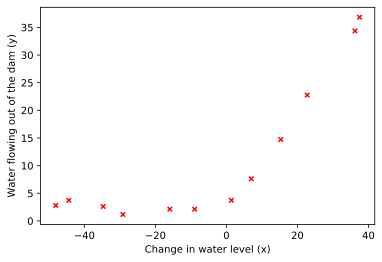

In [3]:
# Plot data
plt.scatter(X, y, marker='x', c = 'r', s = 20)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### Model

In [4]:
# Regularized cost function
def linearRegCostFunction(theta, X, y, lam):
    """ 
    Computes the cost-function and gradient value of the input data
    """
    m = len(y)
    res = X @ theta - y
    J = (1/(2*m)) * np.sum(res ** 2) + (lam/(2*m)) * np.sum(theta[1:] ** 2)
    grad = (1/m) * X.T @ res
    grad[1:] += (lam/m) * theta[1:]
    return (J, grad) 

In [5]:
# Add bias column to X:
Xb = np.c_[np.ones((m, 1)), X]

In [6]:
# Compute cost for some initial theta:
theta_init = np.ones((2, 1))
linearRegCostFunction(theta_init, Xb, y, 1)

(303.9931922202643, array([[-15.30301567],
        [598.25074417]]))

In [7]:
# Training function, note that theta is returned as a 1d array (not a column vector!)
def trainLinearReg(X, y, lam):
    init_theta = np.zeros((X.shape[1], 1))
    return sop.minimize(linearRegCostFunction, x0 = init_theta.ravel(), 
                        jac=True, args = (X, y.ravel(), lam), method='CG').x

In [8]:
# Learn parameter theta and turn it into a column vector:
theta_opt = trainLinearReg(Xb, y, 0)[:, np.newaxis]

### Results

In [9]:
# Best theta
print(theta_opt)

[[13.08790351]
 [ 0.36777923]]


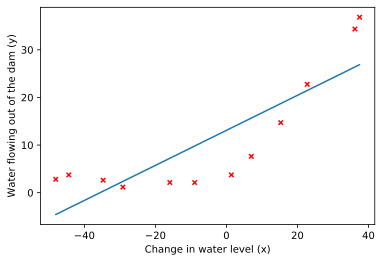

In [10]:
# Plot optimal line
plt.scatter(X, y, marker='x', c = 'r', s = 20)
plt.plot(X, Xb @ theta_opt)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

In [11]:
# Calculate learning curve
def calculateLearningCurve(X, y, Xval, yval, reg):
    m = len(y)
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        theta = trainLinearReg(X[:(i+1), :], y[:(i+1)], reg)[:, np.newaxis]
        error_train[i] = linearRegCostFunction(theta, X[:(i+1), :], y[:(i+1)], 0)[0]
        error_val[i] = linearRegCostFunction(theta, Xval, yval, 0)[0]
    
    return(error_train, error_val)

In [12]:
# Calculate training and cross-validation set errors:
error_train, error_val = calculateLearningCurve(Xb, y, np.c_[np.ones((Xval.shape[0], 1)), Xval], yval, 1)

# Print caclulated errors
errors_datafram = pd.DataFrame({"Training Error": error_train, "Validation Error": error_val}, 
                               index=range(1,m + 1))
errors_datafram

,Training Error,Validation Error
1,3.944305e-31,138.846777
2,1.479610e-05,110.647622
3,3.286615e+00,44.971999
4,2.842689e+00,48.338954
5,1.315405e+01,35.858508
6,1.944397e+01,33.822649
7,2.009852e+01,31.965552
8,1.817286e+01,30.858614
9,2.260941e+01,31.132841
10,2.326146e+01,28.935174


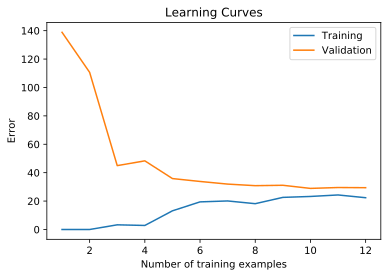

In [13]:
# Plot the learning curves
plt.plot(range(1, 13), error_train.ravel(), label='Training')
plt.plot(range(1, 13), error_val.ravel(), label='Validation')
plt.title('Learning Curves')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

*Notice:* The errors are large for both training and cross-validation sets, indicating high bias, i.e.
the model is to simple to provide a good fit for the given data.

## Polynomial Regression

### Model (without Regularization)

In [14]:
# We try to add polynomial features to train a more complex model
def polyFeatures(X, p):
    if p <= 1:
        return X

    Xpoly = np.zeros((X.shape[0], p))
    
    for i in range(1, p + 1):
        # Notice Xpoly[:, i - 1] returns a 1d array so right hand side must also be a 1d array
        Xpoly[:, i - 1] = X.ravel() ** i
        
    return Xpoly

In [15]:
# Feature scaling function:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mu)/std, mu, std

In [16]:
# We'll use a degree 8 feature map:
p = 8

## Map training set onto polynomial features and normalize (saving the mean and std deviation)
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
# Add bias column
X_poly = np.c_[np.ones((m, 1)), X_poly]

## Map test set and normalize (using mu and sigma from above)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu)/sigma
# Add bias column
X_poly_test = np.c_[np.ones((X_poly_test.shape[0], 1)), X_poly_test]

## Map validation set and normalize (using mu and sigma from above)
X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu)/sigma
# Add bias column
X_poly_val = np.c_[np.ones((X_poly_val.shape[0], 1)), X_poly_val]

In [17]:
# Learn parameter theta for the model with polynomial features using no regularization
theta_opt_poly = trainLinearReg(X_poly, y, 0)[:, np.newaxis]

#### Results

In [18]:
# Plot-function for polynomial regression curve:
def plotFit(min_x, max_x, mu, sigma, theta, p):
    x_lin = np.linspace(min_x - 15, max_x + 10)
    x_lin_poly = polyFeatures(x_lin, p)
    x_lin_poly = (x_lin_poly - mu)/sigma
    x_lin_poly = np.c_[np.ones((x_lin_poly.shape[0], 1)), x_lin_poly]
    
    plt.plot(x_lin, x_lin_poly @ theta)

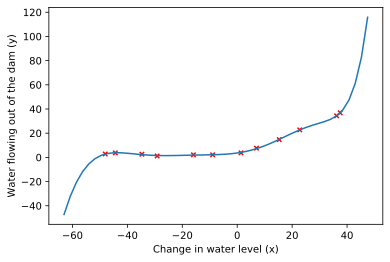

In [19]:
# Plot learned curve
plt.scatter(X, y, marker='x', c = 'r', s = 20)
plotFit(np.min(X), np.max(X), mu, sigma, theta_opt_poly, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

In [20]:
# Calculate training and cross-validation set errors:
error_train_poly, error_val_poly = calculateLearningCurve(X_poly, y, X_poly_val, yval, 0)

# Print caclulated errors
errors_poly_dataframe = pd.DataFrame({"Training Error": error_train_poly, "Validation Error": error_val_poly}, 
                                     index=range(1,m + 1))
errors_poly_dataframe

,Training Error,Validation Error
1,9.860761e-32,161.442168
2,5.053640e-31,160.792292
3,4.617443e-11,67.084922
4,1.282789e-21,67.726849
5,3.109811e-17,6.616987
6,2.412996e-08,10.638414
7,4.662728e-11,27.990042
8,1.886615e-07,22.759617
9,1.405794e-04,30.119190
10,1.083414e-02,94.351205


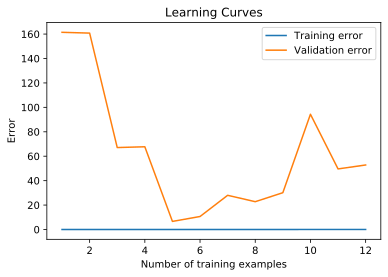

In [21]:
# Plot the learning curves
plt.plot(range(1, 13), error_train_poly, label='Training error')
plt.plot(range(1, 13), error_val_poly, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

*Notice:* The errors are very small ($\approx$0) for the training set, but very large for the validation set and 
there is a gap between the curves which is indicative of high variance in the model.

### Model (with weak Regularization, $\lambda = 1$)

In [22]:
# Learn parameter theta for the model with polynomial features using regularization (lambda = 1)
theta_opt_poly_reg = trainLinearReg(X_poly, y, 1)[:, np.newaxis]

#### Results

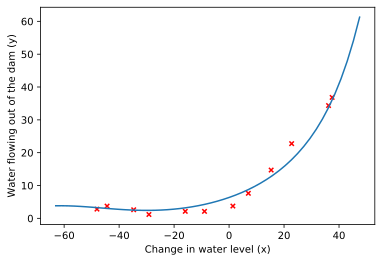

In [23]:
# Plot learned curve, notice the curve captures the trend of the data much more nicely as in the high bias/variance cases
plt.scatter(X, y, marker='x', c = 'r', s = 20)
plotFit(np.min(X), np.max(X), mu, sigma, theta_opt_poly_reg, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

*Notice:* The curve captures the trend of the data more nicely than in the high bias/variance cases.

In [24]:
# Calculate training and cross-validation set errors:
error_train_poly_reg, error_val_poly_reg = calculateLearningCurve(X_poly, y, X_poly_val, yval, 1)

# Print caclulated errors
errors_poly_reg_dataframe = pd.DataFrame({"Training Error": error_train_poly_reg, 
                                          "Validation Error": error_val_poly_reg}, 
                                         index=range(1,m + 1))
errors_poly_reg_dataframe

,Training Error,Validation Error
1,0.000000,138.846777
2,0.042836,143.502691
3,2.515225,5.749579
4,1.285542,6.890097
5,1.028319,6.900654
6,0.794932,8.581215
7,1.409965,5.842281
8,1.316233,5.575902
9,1.458734,6.300257
10,1.353297,6.033544


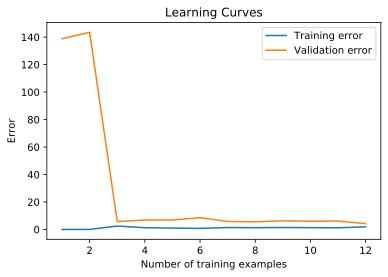

In [25]:
# Plot the learning curves
plt.plot(range(1, 13), error_train_poly_reg, label='Training error')
plt.plot(range(1, 13), error_val_poly_reg, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

*Notice:* Both the training set and the validation set errors are small and there is almost no gap between the two.

### Model (with strong Regularization, $\lambda = 100$)

In [26]:
# Learn parameter theta for the model with polynomial features using high regularization (lambda = 100)
theta_opt_poly_hreg = trainLinearReg(X_poly, y, 100)[:, np.newaxis]

#### Results

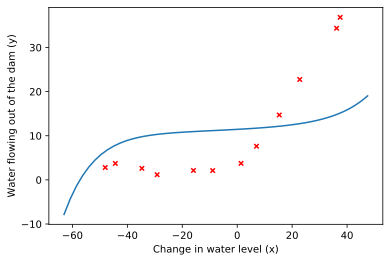

In [27]:
# Plot learned curve, notice the curve captures the trend of the data much more nicely as in the high bias/variance cases
plt.scatter(X, y, marker='x', c = 'r', s = 20)
plotFit(np.min(X), np.max(X), mu, sigma, theta_opt_poly_hreg, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

*Notice:* The curve does not capture the data trend of the data. The large regularization value for $\lambda$ penalizes large $\theta$-values too much.

In [28]:
# Calculate training and cross-validation set errors:
error_train_poly_hreg, error_val_poly_hreg = calculateLearningCurve(X_poly, y, X_poly_val, yval, 100)

# Print caclulated errors
errors_poly_hreg_dataframe = pd.DataFrame({"Training Error": error_train_poly_hreg, "Validation Error": error_val_poly_hreg}, 
                                        index=range(1,m + 1))
errors_poly_hreg_dataframe

,Training Error,Validation Error
1,8.479939e-14,138.846782
2,1.139855e-01,144.124029
3,1.059592e+02,70.036421
4,1.199453e+02,76.910551
5,1.008864e+02,62.513581
6,9.525749e+01,58.094607
7,8.168810e+01,58.149056
8,7.488457e+01,57.213733
9,6.981951e+01,58.029746
10,6.296405e+01,58.171822


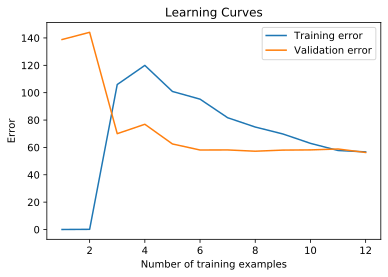

In [29]:
# Plot the learning curves, this is a high bias case, the model doesn't fit either the training set nor the val set
# well
plt.plot(range(1, 13), error_train_poly_hreg, label='Training error')
plt.plot(range(1, 13), error_val_poly_hreg, label='Validation error')
plt.title('Learning Curves')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

*Notice:* This is a high bias case, the model fits neither the training set nor the val set well.

In [30]:
# Define function to record errors for various lambda values:
def validationCurve(X, y, Xval, yval):
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    m = len(lambda_vec)
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        lam = lambda_vec[i]
        theta = trainLinearReg(X, y, lam)[:, np.newaxis]
        error_train[i] = linearRegCostFunction(theta, X, y, 0)[0]
        error_val[i] = linearRegCostFunction(theta, Xval, yval, 0)[0]
    
    return(lambda_vec, error_train, error_val)

In [31]:
# Calculate train and val errors for various lambda values:
lambda_vec, error_train_l, error_val_l = validationCurve(X_poly, y, X_poly_val, yval)

In [32]:
# Print caclulated errors
errors_for_different_lambdas_dataframe = pd.DataFrame({"Training Error": error_train_l, 
                                                       "Validation_Error": error_val_l}, index=lambda_vec)
errors_for_different_lambdas_dataframe.index.rename("$\lambda$", inplace=True)
errors_for_different_lambdas_dataframe

,Training Error,Validation_Error
$\lambda$,,
0.000,0.028898,52.818498
0.001,0.107975,9.368429
0.003,0.166792,15.931215
0.010,0.217977,17.146219
0.030,0.275164,13.216321
0.100,0.438656,7.926859
0.300,0.868166,4.760815
1.000,1.958695,4.263359
3.000,4.525105,3.832176


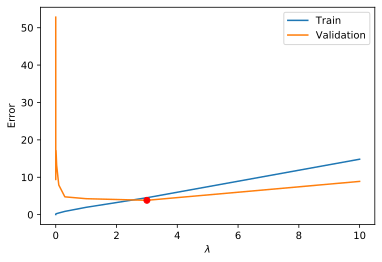

In [33]:
# Plot lambda vs. errors:
plt.plot(lambda_vec, error_train_l, label='Train')
plt.plot(lambda_vec, error_val_l, label='Validation')
plt.scatter(lambda_vec[8], error_val_l[8], color="red", zorder=10)
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.show()

*Conclusion:* The tested lambda value leading to the lowest cross-validation error is lambda = 3 (cross-val error = 3.83)